In [1]:
#Import packages

#basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
import pickle
from pprint import pprint
import gc

import warnings

#nlp
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, Binarizer
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error #roc_auc_score, 
from lightgbm import LGBMClassifier, LGBMRegressor
import re
from collections import Counter
import string
#import nltk
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from wordcloud import WordCloud
import pyLDAvis.gensim
import shap
import joblib

/home/braincourt.de/twalenczak/.local/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/home/braincourt.de/twalenczak/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
#Import preprocessed data sets

preprocessed_text = pickle.load(open("data/preprocessed_text.pkl", "rb"))
all_text = pickle.load(open("data/preprocessed_all_text.pkl", "rb"))
gc.collect()

33

In [9]:
preprocessed_text.head()

,stars,text,classes,text length
483229,2,coming back boulder stopped spice china gone w...,negative,261
489048,1,like ted buford live decatur lots options like...,negative,605
234870,2,got medium size ice cream today featured black...,negative,75
459537,1,november th ordered escovitch fish tough like ...,negative,373
67958,2,dua located downtown atlanta broad street righ...,negative,823


In [10]:
# Cross check why food is still in KMeans
food_docs = preprocessed_text[preprocessed_text['text'].str.contains('food', case=False, na=False)]
food_word_count = Counter(re.sub("[^\w]", " ",  all_text).split())['food']
print('No. of docs with "food" in it:', len(food_docs), '(', (len(food_docs)/60000)*100, '%)')
print('Total count of the word "food":', food_word_count)

invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w


No. of docs with "food" in it: 31012 ( 51.68666666666667 %)
Total count of the word "food": 43088


# Unsupervised data set

## Term frequency

In [19]:
# Term frequency

# Turn all the words into single strings
wordList = re.sub("[^\w]", " ",  all_text).split()
print(len(wordList))
# 2.984.057 words

# Count the words
counts = Counter(wordList)
#print(counts)

# Turn dictionary in a df
count = pd.DataFrame.from_records(list(dict(counts).items()), columns=['word','count'])
print(count.count())
# 95.229 distinct words

# Get the 1 and 99 percentiles of counts as thresholds
p99, p1 = np.round(np.percentile(count['count'], [99 ,1]), 0)
print(p1, p99)

# Drop all above or below the threshold
indexNames = count[(count['count'] <= p1) | (count['count'] >= p99)].index
count.drop(indexNames, inplace=True)
print(count.count())
# 32.009 distinct words remain 

#save file
count.to_csv('importance_measures/word_count_60K_balanced.csv', sep=';', decimal=',')

invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
i

2984057
word     95229
count    95229
dtype: int64
1.0 545.0
word     32009
count    32009
dtype: int64


## Bigrams

<AxesSubplot:>

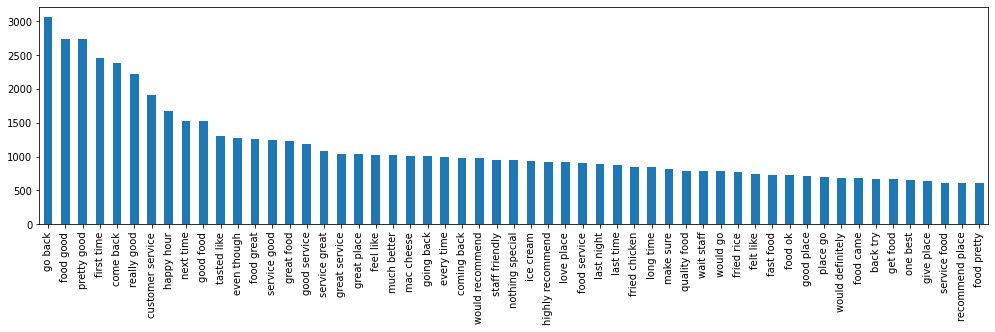

In [20]:
# Calculate Bigrams to find word pairs that frequently occur together

ngram = CountVectorizer(ngram_range=(2,2), max_df=0.99, min_df=0.01)
ngram_fit = ngram.fit_transform(preprocessed_text.text)

# Put results into a df and plot the number of occurences per word pair
col_names = ngram.get_feature_names()
data = ngram_fit.toarray()
ngram_df = pd.DataFrame(data=data, columns=col_names)
ngram_df.sum().sort_values(ascending=False).plot.bar(x=1, y=0, figsize=(17,4))

In [13]:
ngram_df.sum().to_csv('importance_measures/bigram_count_60K_balanced.csv', sep=';', decimal=',')

## TF-IDF on occurence

In [16]:
# Calculate document frequencies
df = df_tfidf.astype(bool).sum(axis=1).to_frame()
print(df.min(), df.max())

0    3006
dtype: int64 0    30017
dtype: int64


<AxesSubplot:xlabel='words'>

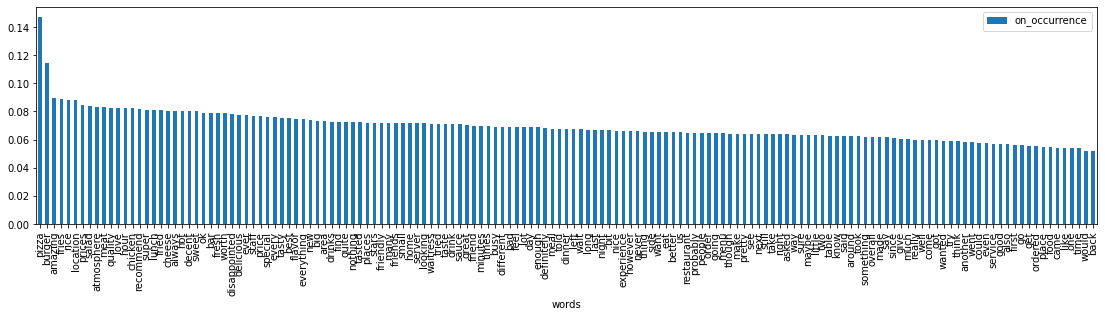

In [3]:
# Calculate TF-IDF per word per review with max_df = 95% and min_df = 5%
vectorizer = TfidfVectorizer(max_df = 0.95, min_df=0.05, norm='l1')

vectors = vectorizer.fit_transform(preprocessed_text.text) 
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df_tfidf = pd.DataFrame(denselist, columns=feature_names).transpose()
df_tfidf['words'] = df_tfidf.index

# Calculate the TF-IDF value a word gets on average if it appears in a review
df_tfidf['on_occurrence'] = df_tfidf.sum(axis=1) / df_tfidf.astype(bool).sum(axis=1)

# and plot the result as a barplot
df_tfidf.sort_values(by='on_occurrence', ascending=False).plot.bar(x='words', y='on_occurrence', figsize=(19,4))

In [17]:
df_tfidf[['words', 'on_occurrence']].to_csv('importance_measures/tfidf_95_60K_balanced.csv', sep=';', decimal=',')

In [18]:
df_99 = df_tfidf_99.astype(bool).sum(axis=1).to_frame()
print(df_99.min(), df_99.max())

0    602
dtype: int64 0    30017
dtype: int64


<AxesSubplot:xlabel='words'>

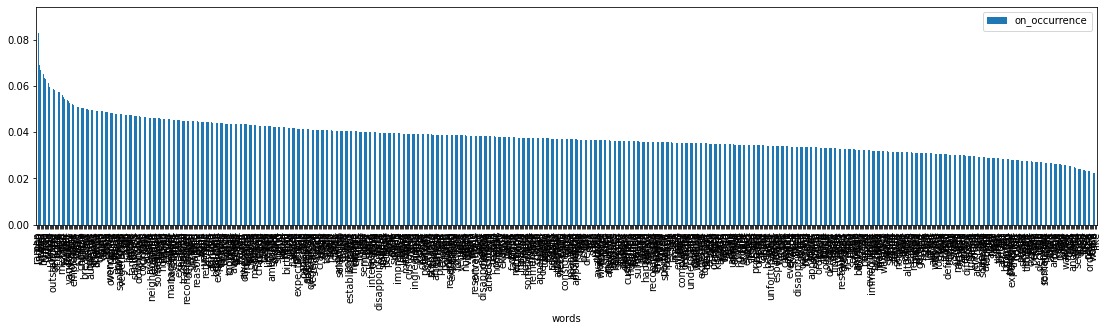

In [17]:
# Calculate TF-IDF per word per review with max_df = 99% and min_df = 1%
vectorizer99 = TfidfVectorizer(max_df = 0.99, min_df=0.01, norm='l1')

vectors = vectorizer99.fit_transform(preprocessed_text.text) 
feature_names = vectorizer99.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df_tfidf_99 = pd.DataFrame(denselist, columns=feature_names).transpose()
df_tfidf_99['words'] = df_tfidf_99.index

# Calculate the TF-IDF value a word gets on average if it appears in a review
df_tfidf_99['on_occurrence'] = df_tfidf_99.sum(axis=1) / df_tfidf_99.astype(bool).sum(axis=1)

# and plot the result as a barplot
df_tfidf_99.sort_values(by='on_occurrence', ascending=False).plot.bar(x='words', y='on_occurrence', figsize=(19,4))

In [19]:
df_tfidf_99[['words', 'on_occurrence']].to_csv('importance_measures/tfidf_99_60K_balanced.csv', sep=';', decimal=',')

## IDF

In [23]:
df_95 = df_idf.astype(bool).sum(axis=0).to_frame()
#print(df_95.min(), df_95.max())

,words,IDF
0,also,2.809838
1,always,3.358467
2,amazing,3.610713
3,another,3.586292
4,area,3.623956
...,...,...
144,way,3.325188
145,well,3.030541
146,went,3.086416
147,worth,3.714840


<AxesSubplot:xlabel='words'>

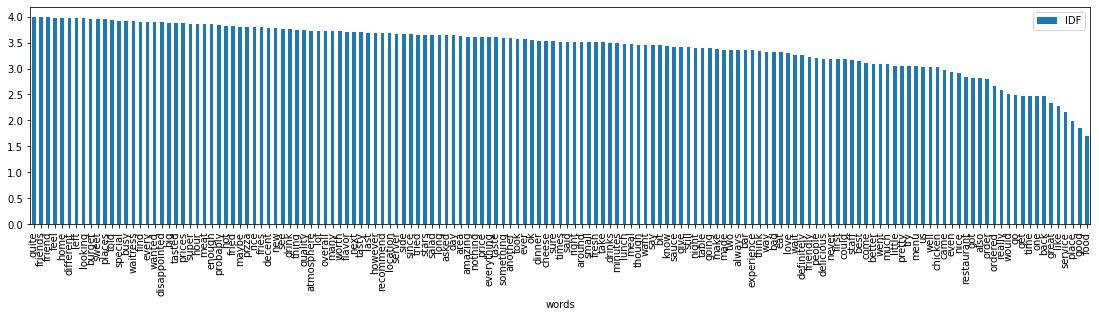

In [19]:
# Calculate IDF per word with max_df = 95% and min_df = 5%
vectorizer = TfidfVectorizer(max_df = 0.95, min_df=0.05, norm='l1')

vectors = vectorizer.fit_transform(preprocessed_text.text) 
feature_names = vectorizer.get_feature_names()
denselist = vectorizer.idf_
df_idf = pd.DataFrame(feature_names, columns=['words'])
df_idf['IDF'] = denselist

# and plot the result as a barplot
df_idf.sort_values(by='IDF', ascending=False).plot.bar(x=0, y=1, figsize=(19,4))

In [21]:
df_idf.to_csv('importance_measures/idf_95_60K_balanced.csv', sep=';', decimal=',')

<AxesSubplot:xlabel='words'>

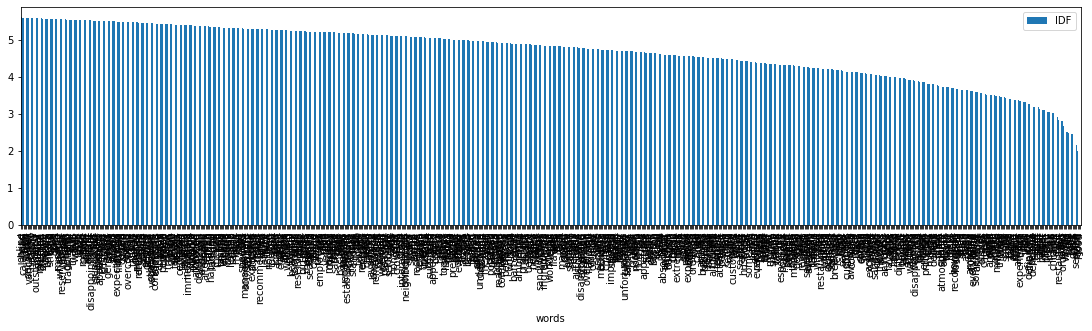

In [22]:
# Calculate IDF per word with max_df = 99% and min_df = 1%
vectorizer99 = TfidfVectorizer(max_df = 0.99, min_df=0.01, norm='l1')

vectors = vectorizer99.fit_transform(preprocessed_text.text) 
feature_names = vectorizer99.get_feature_names()
denselist = vectorizer99.idf_
df_idf_99 = pd.DataFrame(feature_names, columns=['words'])
df_idf_99['IDF'] = denselist

# and plot the result as a barplot
df_idf_99.sort_values(by='IDF', ascending=False).plot.bar(x=0, y=1, figsize=(19,4))

In [23]:
df_idf_99.to_csv('importance_measures/idf_99_60K_balanced.csv', sep=';', decimal=',')

## K-means clustering

In [13]:
#Load and train the model
kmeans = KMeans(n_clusters=3, max_iter=1000, random_state=42)
kmeans.fit(df_tfidf.drop(['words', 'per_occurrence'], axis=1).transpose())

#display important words per cluster
words = vectorizer.get_feature_names()
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ' , '.join(words[word] for word in centroid))

0 : pizza , good , place , cheese , great , like , order , ordered , sauce , best
1 : food , great , good , service , place , friendly , staff , nice , really , delicious
2 : good , food , place , like , one , get , time , go , would , back


## LDA

In [25]:
#preprocess reviews
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))
        
reviews = preprocessed_text.text.values.tolist()
reviews_words = list(sent_to_words(reviews))
#print(reviews_words[:1][0])

# Create Dictionary
id2word = corpora.Dictionary(reviews_words)
id2word.filter_extremes(no_below=602, no_above=0.95)
# Create Corpus
texts = reviews_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
#print(corpus[:1][0][:30])

# number of topics
num_topics = 3
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 3 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.021*"food" + 0.016*"good" + 0.011*"would" + 0.011*"great" + 0.010*"get" + '
  '0.010*"place" + 0.009*"like" + 0.009*"really" + 0.008*"one" + '
  '0.008*"service"'),
 (1,
  '0.023*"food" + 0.015*"good" + 0.015*"place" + 0.014*"like" + 0.013*"go" + '
  '0.013*"service" + 0.012*"back" + 0.009*"really" + 0.009*"time" + '
  '0.009*"great"'),
 (2,
  '0.022*"food" + 0.021*"good" + 0.020*"place" + 0.012*"service" + '
  '0.011*"great" + 0.010*"time" + 0.010*"one" + 0.009*"get" + 0.008*"like" + '
  '0.008*"order"')]


### pyLDAvis

In [64]:
lda_display = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, sort_topics=False)
pyLDAvis.display(lda_display)

#--> not too useful

In [65]:
gc.collect()

373

# Supervised data

In [3]:
# Encode the augmented class
encode_classes_dict = {
    'positive' : 2,
    'neutral' : 1,
    'negative' : 0}

preprocessed_text['encoded'] = [encode_classes_dict[x] for x in preprocessed_text.classes]

In [4]:
# Split the data into train and test
reviews_train, reviews_test, y_train, y_test = train_test_split(preprocessed_text.text, preprocessed_text.encoded,
                                                                test_size = 0.2, random_state = 42,
                                                                stratify=preprocessed_text.encoded)

## RandomForest

###### One hot

In [19]:
# One hot encoding with outlier removal

cv = CountVectorizer(max_df=0.99, min_df=0.01)
vector_train = cv.fit_transform(reviews_train)
Bi = Binarizer()
bi_train = Bi.fit_transform(vector_train)
vector_test = cv.transform(reviews_test)
bi_test = Bi.transform(vector_test)

start = time.time()
param_grid_bi = {'max_depth': [50], #[30, 50, 100]
                 'min_samples_leaf': [10], #[5, 10, 20]
                 'n_estimators': [1000]} #[50, 500, 1000]}

clf_bi = RandomForestClassifier(random_state = 21)
grid_search_bi = GridSearchCV(estimator=clf_bi, param_grid=param_grid_bi, cv=3)
grid_search_bi.fit(bi_train, y_train)

end = time.time()
print('Training RF on', len(y_train), 'reviews took', end - start, 's.\n')

print(grid_search_bi.best_params_)

# Predict labels and check performance
best_rf_bi = grid_search_bi.best_estimator_
y_pred = best_rf_bi.predict(bi_test)

acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("\nThe model's accuracy on the test set is: {0}" .format(acc))
print(report)

score = best_rf_bi.score(bi_train ,y_train)
print("The model's accuracy on the train set is: {0}" .format(score))

# Testing history
# 5-95 percentile
# max_depth: 50, min_samples_leaf: 10, n_estimators: 1000 : 0.62583 --> no overfit (0.70235)

# 1-99 percentile:
# 60K, max_depth: 100, min_samples_leaf: 5, n_estimators: 1000 : 0.68 --> no overfit (0.81)
# 60K, max_depth: 50, min_samples_leaf: 5, n_estimators: 1000 : 0.68 --> no overfit (0.81)
# 60K, max_depth: 25, min_samples_leaf: 10, n_estimators: 1000 : 0.67 --> no overfit (0.72)
# 60K, max_depth: 50, min_samples_leaf: 10, n_estimators: 1000 : 0.67 --> no overfit (0.74)

Training RF on 48000 reviews took 1153.0111861228943 s.

{'max_depth': 50, 'min_samples_leaf': 10, 'n_estimators': 1000}

The model's accuracy on the test set is: 0.67475
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      4000
           1       0.59      0.56      0.57      4000
           2       0.71      0.75      0.73      4000

    accuracy                           0.67     12000
   macro avg       0.67      0.67      0.67     12000
weighted avg       0.67      0.67      0.67     12000

The model's accuracy on the train set is: 0.7435208333333333


In [8]:
# Extract importances based on feature permutation
# (because this method is not biased towards high-cardinality features like text)

start_time = time.time()
result = permutation_importance(
    best_rf_bi, bi_test.toarray(), y_test, random_state=42)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 12607.865 seconds


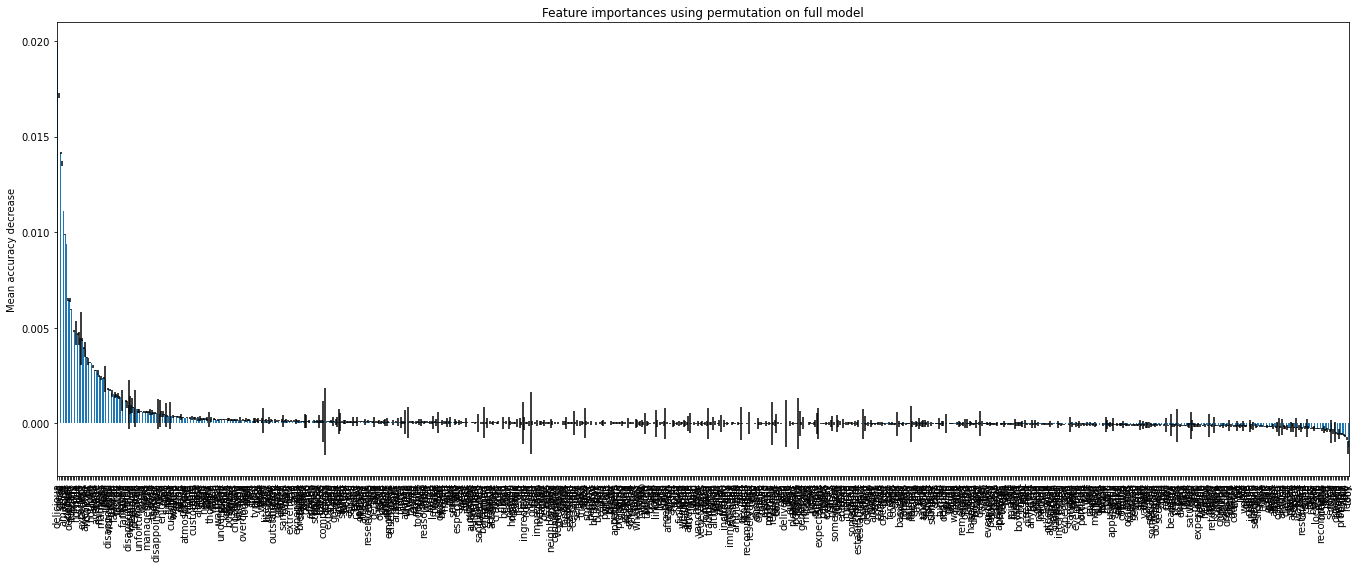

In [9]:
# Show the importances

feature_names = cv.get_feature_names()
forest_importances = pd.Series(result.importances_mean, index=feature_names)
fig, ax = plt.subplots()
forest_importances.sort_values(ascending=False).plot.bar(yerr=result.importances_std, ax=ax, figsize=(19,8))
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [10]:
# Safe feature importance values to csv 
forest_importances.to_csv('importance_measures/RF_1HOT_FI_60K_reviews_balance.csv', sep=';', decimal=',')

###### TF-IDF

In [20]:
# Initialize a pipeline of Tf-Idf Vectorizer and RFClassifier

vectorizer = TfidfVectorizer(max_df=0.99, min_df=0.01, norm='l1')
tf_train = vectorizer.fit_transform(reviews_train)
tf_test = vectorizer.transform(reviews_test)

start = time.time()
param_grid_rf = {'max_depth': [50], #[30, 50, 100]
                 'min_samples_leaf': [10], #[5, 10, 20]
                 'n_estimators': [1000]} #[50, 500, 1000]}

clf = RandomForestClassifier(random_state = 21)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid_rf, cv=3)
grid_search.fit(tf_train, y_train)

end = time.time()
print('Training RF on', len(y_train), 'reviews took', end - start, 's.\n')
    
print(grid_search.best_params_)

# Predict labels and check performance
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(tf_test)

acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("\nThe model's accuracy on the test set is: {0}" .format(acc))
print(report)

# Check on overfitting
score = best_rf.score(tf_train ,y_train)
print("The model's accuracy on the train set is: {0}" .format(score))

# Testing history
# 5-95 percentile
# max_depth: 50, min_samples_leaf: 10, n_estimators: 1000 : 0.62558 --> no overfit (0.75477)

# 1-99 percentile:
# 60K + max_depth: 25, min_samples_leaf: 10, n_estimators: 1000 : 0.67 --> no overfit (0.73)
# 60K + max_depth: 50, min_samples_leaf: 10, n_estimators: 1000 : 0.67 --> no overfit (0.78)

Training RF on 48000 reviews took 1444.322027206421 s.

{'max_depth': 50, 'min_samples_leaf': 10, 'n_estimators': 1000}

The model's accuracy on the test set is: 0.6743333333333333
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      4000
           1       0.59      0.57      0.58      4000
           2       0.71      0.73      0.72      4000

    accuracy                           0.67     12000
   macro avg       0.67      0.67      0.67     12000
weighted avg       0.67      0.67      0.67     12000

The model's accuracy on the train set is: 0.7798333333333334


In [11]:
# Extract importances based on feature permutation
# (because this method is not biased towards high-cardinality features like text)

start_time = time.time()
result = permutation_importance(
    best_rf, tf_test.toarray(), y_test, random_state=42)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 12818.181 seconds


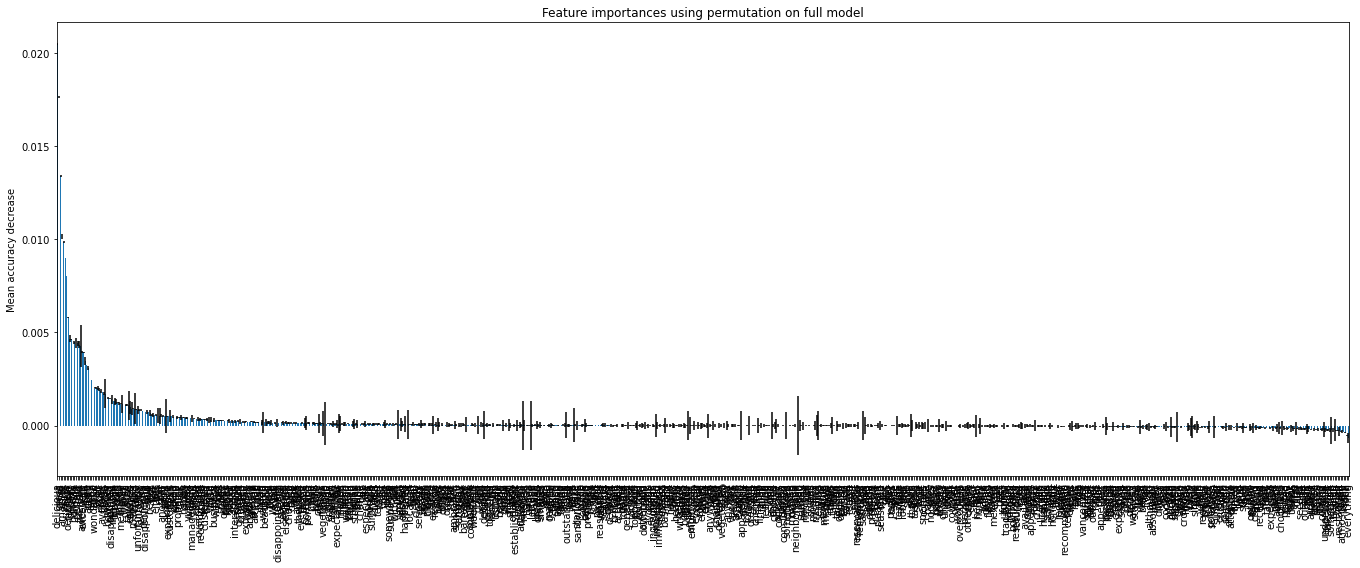

In [12]:
# Show the importances

feature_names = vectorizer.get_feature_names()
forest_importances = pd.Series(result.importances_mean, index=feature_names)
fig, ax = plt.subplots()
forest_importances.sort_values(ascending=False).plot.bar(yerr=result.importances_std, ax=ax, figsize=(19,8))
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [13]:
# Safe feature importance values to csv 
forest_importances.to_csv('importance_measures/RF_TFIDF_FI_60K_reviews_balance.csv', sep=';', decimal=',')

In [14]:
gc.collect()

0

## LightGBM

##### One-Hot

In [11]:
# One hot encoding with outlier removal
# turn binary/integer sparse vectors to float for LGBM 

cv = CountVectorizer(max_df=0.99, min_df=0.01)
vector_train = cv.fit_transform(reviews_train)
Bi = Binarizer()
bi_train = Bi.fit_transform(vector_train).astype(np.float64)
vector_test = cv.transform(reviews_test)
bi_test = Bi.transform(vector_test).astype(np.float64)

In [12]:
# Train LightGBM model

param_grid_lgbm_bi = {
    'num_leaves': [50], #[30, 50, 80]
    'max_depth': [25], #[5, 15, 25] 
    'min_data_in_leaf': [50] #[10, 50, 100]
    }

lgbm_bi = LGBMClassifier(random_state = 42)
g_s_bi = GridSearchCV(estimator=lgbm_bi, param_grid=param_grid_lgbm_bi, cv=3)
g_s_bi.fit(bi_train, y_train)

best_lgbm_bi = g_s_bi.best_estimator_
y_pred2 = best_lgbm_bi.predict(bi_test)

acc2 = accuracy_score(y_test, y_pred2)
report2 = classification_report(y_test, y_pred2)
print("\nThe model's accuracy on the test set is: {0}" .format(acc2))
print(report2)

print(g_s_bi.best_params_)

# Check on overfitting
score2 = best_lgbm_bi.score(bi_train ,y_train)
print("\nThe model's accuracy on the train set is: {0}" .format(score2))

# Testing history
# 5-95 percentile: 
# 60K + max_depth: 25, min_data_in_leaf: 50, num_leaves: 50 : 0.6424 --> no overfit (0.7107)

# 1-99 percentile:
# 60K reviews + balanced + max_depth: 15, min_data_in_leaf: 50, num_leaves: 50 : 0.696 --> no overfit (0.77)
# 60K reviews + balanced + max_depth: 25, min_data_in_leaf: 50, num_leaves: 50 : 0.707 --> no overfit (0.784)

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50

The model's accuracy on the test set is: 0.70675
              precision    recall  f1-score   support

           0       0.76      0.75      0.75      4000
           1       0.61      0.61      0.61      4000
           2       0.75      0.77      0.76      4000

    accuracy                           0.71     12000
   macro avg       0.71      0.71      0.71     12000
weighted avg       0.71      0.71      0.71     12000

{'max_depth': 25, 'min_data_in_leaf': 50, 'num_leaves': 50}

The model's accuracy

In [13]:
gc.collect()

169

##### Extract SHAP values

In [9]:
# put tf-idf scores of words per document of all reviews (train+test) in a df

feature_names = cv.get_feature_names()
df_bi_train = pd.DataFrame(bi_train.todense().tolist(), columns=feature_names)
df_bi_test = pd.DataFrame(bi_test.todense().tolist(), columns=feature_names)
df_bi2 = pd.concat([df_bi_train, df_bi_test])

df_bi2.head()

,able,absolutely,across,actually,add,added,afternoon,ago,almost,along,...,would,wow,write,wrong,year,years,yelp,yes,yet,yummy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# Explain results using SHAP
start = time.time()
explainer = shap.TreeExplainer(best_lgbm_bi)
intermediate = time.time()
print('Explainer took', intermediate - start, 's.')

shap_values_bi = explainer.shap_values(df_bi2, check_additivity=True)
end = time.time()
print('Shap values took', (end - intermediate)/60, 'min.')

Explainer took 0.7466940879821777 s.
Shap values took 9.42493671576182 min.


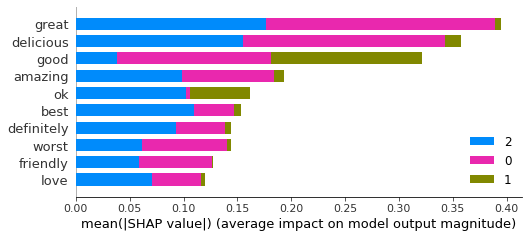

In [11]:
shap.summary_plot(shap_values_bi, df_bi2, max_display=10, plot_size=0.2, class_names=best_lgbm_bi.classes_)

In [12]:
# Transform all SHAP values of classes into one df for 3 classes

# Calculate the mean of the absolut value of each word over all samples for class negative
shap_feature = np.abs(shap_values_bi[0]).mean(axis=0)
feature_importances_0 = pd.DataFrame({'feature name': df_bi2.columns, 'SHAP negative': shap_feature})

# Calculate the mean of the absolut value of each word over all samples for class neutral
shap_feature = np.abs(shap_values_bi[1]).mean(axis=0)
feature_importances_1 = pd.DataFrame({'SHAP neutral': shap_feature, 'feature name': df_bi2.columns})

# Calculate the mean of the absolut value of each word over all samples for class positive
shap_feature = np.abs(shap_values_bi[2]).mean(axis=0)
feature_importances_2 = pd.DataFrame({'SHAP positive': shap_feature, 'feature name': df_bi2.columns})

shap_ovr_bi = pd.concat([feature_importances_0, feature_importances_1['SHAP neutral'], feature_importances_2['SHAP positive']], axis=1)
shap_ovr_bi['sum'] = shap_ovr_bi.sum(axis=1)
shap_ovr_bi['avg'] = shap_ovr_bi.mean(axis=1)
shap_ovr_bi.sort_values(by='avg', ascending=False)

,feature name,SHAP negative,SHAP neutral,SHAP positive,sum,avg
306,great,0.212774,0.005598,0.176412,0.394784,0.197392
173,delicious,0.187260,0.014372,0.155700,0.357332,0.178666
301,good,0.143111,0.139610,0.038411,0.321132,0.160566
15,amazing,0.085271,0.009186,0.098894,0.193351,0.096676
479,ok,0.004458,0.055360,0.101889,0.161707,0.080853
...,...,...,...,...,...,...
119,chili,0.000000,0.000000,0.000000,0.000000,0.000000
25,appetizers,0.000000,0.000000,0.000000,0.000000,0.000000
810,whatever,0.000000,0.000000,0.000000,0.000000,0.000000
698,summer,0.000000,0.000000,0.000000,0.000000,0.000000


In [13]:
shap_ovr_bi.to_csv('importance_measures/LGBM_1HOT_SHAP_60K_balance.csv', sep=';', decimal=',')

##### TF-IDF

In [14]:
# Transform reviews into Tf-Idf vectors
vectorizer = TfidfVectorizer(max_df=0.99, min_df=0.01, norm='l1')
tf_train = vectorizer.fit_transform(reviews_train)
tf_test = vectorizer.transform(reviews_test)

In [15]:
# Train LightGBM model

param_grid_lgbm = {
    'num_leaves': [50], #[30, 50, 80] 
    'max_depth': [25], #[5, 15, 25]
    'min_data_in_leaf': [50] #[10, 50, 100]
    }
lgbm = LGBMClassifier(random_state = 42)
g_s = GridSearchCV(estimator=lgbm, param_grid=param_grid_lgbm, cv=3)
g_s.fit(tf_train, y_train)

best_lgbm = g_s.best_estimator_
y_pred2 = best_lgbm.predict(tf_test)

acc2 = accuracy_score(y_test, y_pred2)
report2 = classification_report(y_test, y_pred2)
print("\nThe model's accuracy on the test set is: {0}" .format(acc2))
print(report2)

print(g_s.best_params_)

# Check on overfitting
score2 = best_lgbm.score(tf_train ,y_train)
print("\nThe model's accuracy on the train set is: {0}" .format(score2))

# Testing history
# 5-95 percentile:
# 60K + max_depth: 25, min_data_in_leaf: 50, num_leaves: 50: 0.6422 --> no overfit (0.7422)

# 1-99 percentile:
# 60K + max_depth: 10, min_data_in_leaf: 200, num_leaves: 31: 0.696 --> no overfit (0.74)
# 60K + max_depth: 25, min_data_in_leaf: 100, num_leaves: 50: 0.708 --> no overfit (0.81)
# 60K + max_depth: 25, min_data_in_leaf: 50, num_leaves: 50: 0.703 --> no overfit (0.808)
# 60K + max_depth: 25, min_data_in_leaf: 50, num_leaves: 50: 0.71 --> no overfit (0.806)

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50

The model's accuracy on the test set is: 0.7095
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      4000
           1       0.61      0.62      0.62      4000
           2       0.76      0.77      0.76      4000

    accuracy                           0.71     12000
   macro avg       0.71      0.71      0.71     12000
weighted avg       0.71      0.71      0.71     12000

{'max_depth': 25, 'min_data_in_leaf': 50, 'num_leaves': 50}

The model's accuracy 

In [16]:
gc.collect()

169

##### Extract SHAP values

In [17]:
# put tf-idf scores of words per document of all reviews (train+test) in a df

feature_names = vectorizer.get_feature_names()
df_tf_train = pd.DataFrame(tf_train.todense().tolist(), columns=feature_names)
df_tf_test = pd.DataFrame(tf_test.todense().tolist(), columns=feature_names)
df_tfidf2 = pd.concat([df_tf_train, df_tf_test])

df_tfidf2.head()

,able,absolutely,across,actually,add,added,afternoon,ago,almost,along,...,would,wow,write,wrong,year,years,yelp,yes,yet,yummy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.011925,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041606,...,0.019899,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [18]:
# Fit explainer on train data
start = time.time()
explainer = shap.TreeExplainer(best_lgbm)
intermediate = time.time()
print('Explainer took', intermediate - start, 's.')

shap_values = explainer.shap_values(df_tfidf2, check_additivity=True)
end = time.time()
print('Shap values took', (end - intermediate)/60, 'min.')

Explainer took 0.7914066314697266 s.
Shap values took 12.257611429691314 min.


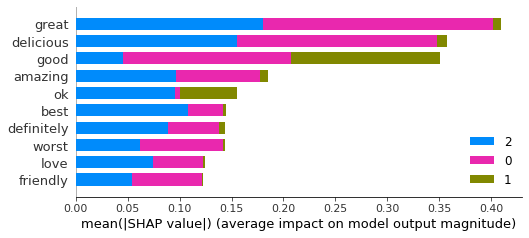

In [19]:
# Plot shap values
shap.summary_plot(shap_values, df_tfidf2, max_display=10, plot_size=0.2, class_names=best_lgbm.classes_)

In [20]:
# Transform all SHAP values of classes into one df for 3 classes

# Calculate the mean of the absolut value of each word over all samples for class negative
shap_feature = np.abs(shap_values[0]).mean(axis=0)
feature_importances_0 = pd.DataFrame({'feature name': df_tfidf2.columns, 'SHAP negative': shap_feature})

# Calculate the mean of the absolut value of each word over all samples for class neutral
shap_feature = np.abs(shap_values[1]).mean(axis=0)
feature_importances_1 = pd.DataFrame({'SHAP neutral': shap_feature, 'feature name': df_tfidf2.columns})

# Calculate the mean of the absolut value of each word over all samples for class positive
shap_feature = np.abs(shap_values[2]).mean(axis=0)
feature_importances_2 = pd.DataFrame({'SHAP positive': shap_feature, 'feature name': df_tfidf2.columns})

shap_ovr = pd.concat([feature_importances_0, feature_importances_1['SHAP neutral'], feature_importances_2['SHAP positive']], axis=1)
shap_ovr['sum'] = shap_ovr.sum(axis=1)
shap_ovr['avg'] = shap_ovr.mean(axis=1)
shap_ovr.sort_values(by='sum', ascending=False)

,feature name,SHAP negative,SHAP neutral,SHAP positive,sum,avg
306,great,0.222106,0.007352,0.180087,0.409545,0.204773
173,delicious,0.192883,0.009711,0.155036,0.357630,0.178815
301,good,0.161839,0.143590,0.045329,0.350758,0.175379
15,amazing,0.081145,0.007734,0.096705,0.185585,0.092793
479,ok,0.004530,0.055066,0.095640,0.155236,0.077618
...,...,...,...,...,...,...
119,chili,0.000000,0.000000,0.000000,0.000000,0.000000
698,summer,0.000000,0.000000,0.000000,0.000000,0.000000
340,house,0.000000,0.000000,0.000000,0.000000,0.000000
708,taco,0.000000,0.000000,0.000000,0.000000,0.000000


In [21]:
# Safe SHAP values to csv 
shap_ovr.to_csv('importance_measures/LGBM_TFIDF_SHAP_60K_balance.csv', sep=';', decimal=',')